In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage
from kornia.utils.one_hot import one_hot

import torch
from torch import nn
import torch.nn.functional as F

In [2]:
import os, sys
sys.path.append(os.path.abspath('..'))

from src.metrics_acdc import load_nii
from src.data.cine2gridtag import sim_gridtag, mod_contrast
from src.training.metrics import DiceLoss

from src.data.utils import Patient
from src.data.datasets import ACDCDataset
from src.models.unet import UNet

In [10]:
from src.training.metrics import ShapeLoss, RegionLoss

In [3]:
dataset = ACDCDataset('../../training/', verbose=1)

Loaded saved dataset of 951 images from /workspace/dev/tagroi/checkpoints/acdc_dataset_tagged.pt


In [4]:
image, mask = dataset[800]

In [5]:
model: nn.Module = UNet(n_channels=1, n_classes=4, bilinear=True).double()
saved_model: nn.Module = torch.load('../checkpoints/model/model_cine_tag_v1_sd.pt')
if isinstance(saved_model, nn.DataParallel):
    saved_model = saved_model.module
model.load_state_dict(saved_model)

<All keys matched successfully>

In [6]:
output = model(image.double().unsqueeze(0))
out = F.softmax(output, dim=1).argmax(dim=1).detach().numpy()[0]

raw_out = output.detach().cpu().numpy()

In [19]:
ce = nn.CrossEntropyLoss()

ce(output, mask.long().unsqueeze(0))

tensor(0.0437, dtype=torch.float64, grad_fn=<NllLoss2DBackward0>)

In [24]:
dsc = DiceLoss(exclude_bg=True)

dsc(output, mask.long().unsqueeze(0))

tensor(0.2390, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [17]:
sl = ShapeLoss(exclude_bg=True)
rl = RegionLoss(exclude_bg=True)

sl(output, mask.long().unsqueeze(0)), rl(output, mask.long().unsqueeze(0))

(tensor(0.2367, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0059, dtype=torch.float64, grad_fn=<MeanBackward0>))

<AxesSubplot:>

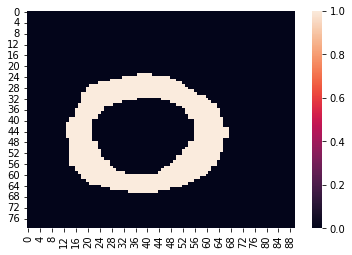

In [9]:
sns.heatmap((mask == 2)[70:150, 70:160])

<AxesSubplot:>

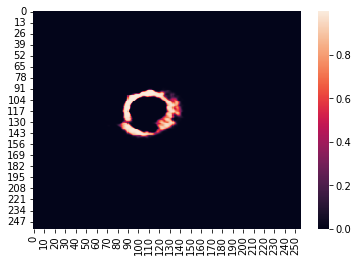

In [10]:
sns.heatmap(F.softmax(output, dim=1)[0, 2].detach().numpy())

In [11]:
i = 2

p = F.softmax(output, dim=1)[0, i]
g = (mask == i).int()

In [12]:
(g * (1 - p) + (1 - g) * p).sum()

tensor(935.3979, dtype=torch.float64, grad_fn=<SumBackward0>)

In [13]:
inp = F.softmax(output, dim=1)
target_one_hot = one_hot(mask.unsqueeze(0).long(), num_classes=output.shape[1], dtype=output.dtype)

In [14]:
rl = (target_one_hot * (1 - inp) + (1 -  target_one_hot) * inp).sum(dim=(2, 3)) / output[0, 0].numel()
rl.sum()

tensor(0.0571, dtype=torch.float64, grad_fn=<SumBackward0>)

<AxesSubplot:>

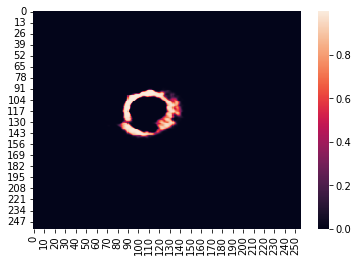

In [15]:
sns.heatmap(inp.detach().numpy()[0, 2])

<AxesSubplot:>

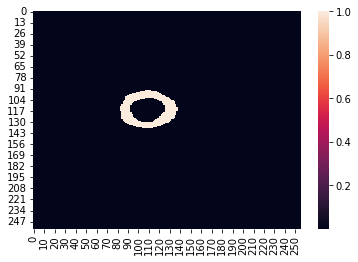

In [16]:
sns.heatmap(target_one_hot.numpy()[0, 2])

In [17]:
sdm = torch.Tensor()

for _class in range(4):
    roi = target_one_hot.int().numpy()[0, _class]

    dt_r = ndimage.distance_transform_edt(roi)
    dt = dt_r / (dt_r.max() + 1e-8)

    dt_neg_r = ndimage.distance_transform_edt(1 - roi)
    dt_neg = dt_neg_r / (dt_neg_r.max() + 1e-8)

    si = (1 - dt) * roi + (-1 + dt_neg) * (1 - roi)
    _sdm = torch.Tensor(1 / (1 + np.exp(-si / 2.))).unsqueeze(0)

    sdm = torch.cat([sdm, _sdm], axis=0)

<AxesSubplot:>

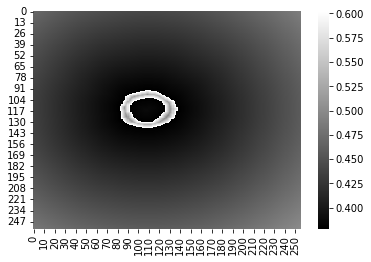

In [18]:
sns.heatmap(sdm[2], cmap='gray')

In [19]:
a = (sdm.unsqueeze(0) * F.softmax(output, dim=1)).abs().sum(dim=(2, 3)) / output[0, 0].numel()

In [20]:
a.squeeze()

tensor([0.5454, 0.0056, 0.0073, 0.0089], dtype=torch.float64,
       grad_fn=<SqueezeBackward0>)

In [21]:
torch.sum(a)

tensor(0.5672, dtype=torch.float64, grad_fn=<SumBackward0>)